# CIFAR 10 Classification: TPU Version

The goal of this notebook is to implement a simple conv net to classify CIFAR10 images using TPU and compare its training time against GPU on local workstation and Colab GPU.

In [0]:
import os
from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import tensorflow as tf
from tensorflow.keras import backend as K

# Dataset

Load CIFAR10 dataset

In [4]:
from tensorflow.keras.datasets import cifar10, mnist

(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
print('x_train_full shape: {}, y_train_full.shape: {}'
      .format(x_train_full.shape, y_train_full.shape))
print('x_test shape: {}, y_test.shape: {}'.format(x_test.shape, y_test.shape))

x_train_full shape: (50000, 32, 32, 3), y_train_full.shape: (50000, 1)
x_test shape: (10000, 32, 32, 3), y_test.shape: (10000, 1)


In [5]:
y_train_full = y_train_full.reshape(y_train_full.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)
print('y_train_full shape: {}, y_test shape: {}'
      .format(y_train_full.shape, y_test.shape))

y_train_full shape: (50000,), y_test shape: (10000,)


In [6]:
# create validation set
split = 0.2
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42)
print('x_train: {}, y_train: {}, x_val: {}, y_val: {}'
      .format(x_train.shape, y_train.shape, x_val.shape, y_val.shape))

x_train: (40000, 32, 32, 3), y_train: (40000,), x_val: (10000, 32, 32, 3), y_val: (10000,)


Lets plot 25 random images to get some idea about the dataset

In [0]:
# pick 25 random images and plot
idxs = np.random.randint(x_train.shape[0], size=25)
images = x_train[idxs]
labels = y_train[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

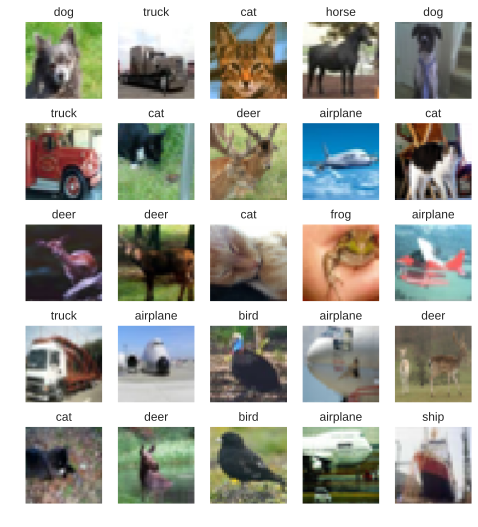

In [8]:
fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])

plt.show()

In [0]:
# Using Dataset
# def scale(x, min_val=0.0, max_val=255.0):
#   x = tf.to_float(x)
#   return tf.div(tf.subtract(x, min_val), tf.subtract(max_val, min_val))

# convert to dataset
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_ds = train_ds.map(lambda x, y: (scale(x), tf.one_hot(y, 10))).shuffle(10000)

# test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# test_ds = test_ds.map(lambda x, y: (scale(x), tf.one_hot(y, 10))).shuffle(10000)

# def train_generator(batch_size):
#   while True:
#     images, labels = train_ds.batch(batch_size).make_one_shot_iterator().get_next()
#     yield images, labels

In [0]:
def train_gen(batch_size):
  while True:
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]

# Build a model

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
__________

# Train

Train the model on TPU

In [12]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.17.106.138:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3788293867414123363)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14218655969421810422)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 5812111958003439941)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8454891999339572241)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15413725777721296706)
INFO:tensorflow:*** Available Device: _Devic

In [0]:
tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

In [14]:
%%time
batch_size = 1024
history = tpu_model.fit_generator(
    train_gen(batch_size), epochs=25, 
    steps_per_epoch=np.ceil(x_train.shape[0]/batch_size),
    validation_data = (x_val, y_val),
)

Epoch 1/25
INFO:tensorflow:New input shapes; (re-)compiling: mode=train, [TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='conv2d_input0'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='activation_target0')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 2.0243589878082275 secs
INFO:tensorflow:Setting weights on TPU model.
39/40 [============================>.] - ETA: 0s - loss: 2.2382 - sparse_categorical_accuracy: 0.2308INFO:tensorflow:New input shapes; (re-)compiling: mode=eval, [TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='conv2d_input0'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='activation_target0')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 0.8057072162628174 se

### Plot Loss and Accuracy

Lets see how did we do on training and validation sets

In [0]:
def plot(losses, accuracies, subplot_title):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  ax1.plot(losses)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  
  ax2.plot(accuracies)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
    
  plt.show()

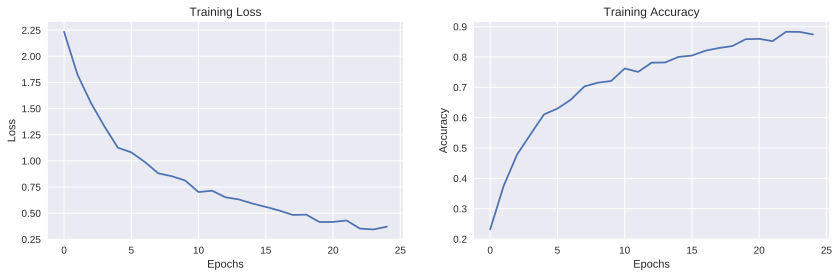

In [16]:
# Training
plot(history.history['loss'], 
     history.history['sparse_categorical_accuracy'], 
     subplot_title=['Training Loss', 'Training Accuracy']
    )

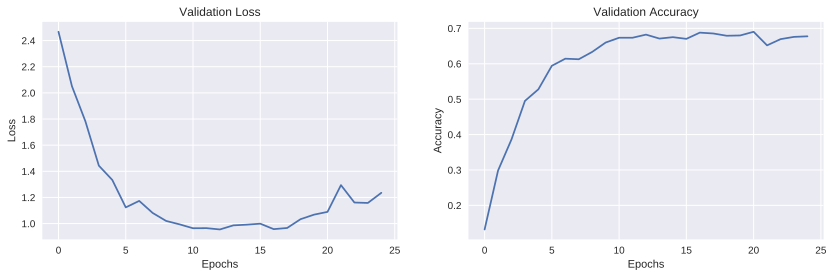

In [17]:
# Validation
plot(history.history['val_loss'], 
     history.history['val_sparse_categorical_accuracy'], 
     subplot_title=['Validation Loss', 'Validation Accuracy']
    )

# Test accuracy

Next, we plot the model predictions on test set

In [18]:
cpu_model = tpu_model.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU


In [0]:
idxs = np.random.randint(x_test.shape[0], size=25)
images = x_test[idxs]
true_labels = y_test[idxs]

preds = np.argmax(cpu_model.predict(images), axis=1)

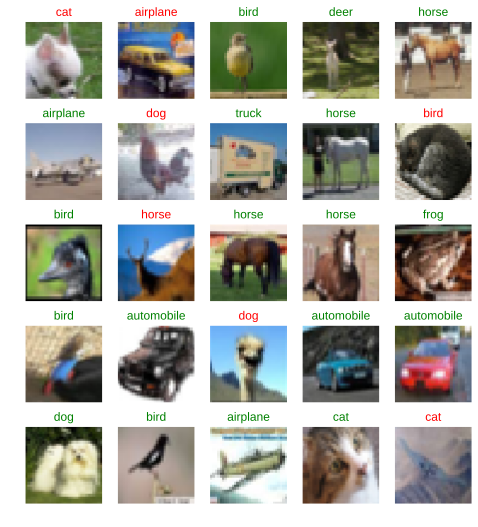

In [20]:
fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = preds[i]
  color = 'g' if idx == true_labels[i] else 'r'
  ax.set_title(classnames[idx], color=color)

plt.show()

Now that we've got the basic model working, you can try improving its accuracy. 
For example, you can try :
* preprocessing
* transfer learning
* learning rates using learning rate finder
* different network architecture


You can try to match/beat the CIFAR10 accuracy listed on this <a href="http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130">page</a>.